In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, classification_report, auc, precision_recall_curve
from scipy import stats
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from pandas.tseries.holiday import USFederalHolidayCalendar

In [2]:
data = pd.read_csv('cleaned_data/feature_set1.csv', index_col=[0,1])
data.index = data.index.set_levels(pd.to_datetime(data.index.levels[0]), level=0)

In [3]:
data.head()

perc_holding  mean_weight  median_weight  \
rebalance_date ticker                                             
2001-08-15     GE           0.87500     0.274133       0.240465   
               PFE          0.84375     0.011433       0.009863   
               MSFT         0.81250     0.008682       0.006144   
               INTC         0.81250     0.009413       0.009634   
               JNJ          0.78125     0.015712       0.013860   

                       perc_25_weight  perc_75_weight  last_21d_ret  \
rebalance_date ticker                                                 
2001-08-15     GE            0.183416        0.369918     -0.092388   
               PFE           0.007516        0.012487      0.064541   
               MSFT          0.003021        0.009056     -0.099276   
               INTC          0.004311        0.012153      0.015683   
               JNJ           0.010072        0.020424      0.037880   

                       last_42d_ret  last_63d_ret  future_ret  
rebalance_date ticker                                          
2001-08-15     GE         -0.142150     -0.198015   -0.020835  
               PFE        -0.036594     -0.079561    0.031055  
               MSFT       -0.048956     -0.064633    0.043512  
               INTC        0.097143      0.070836    0.052513  
               JNJ         0.095119      0.146527    0.057328

In [4]:
X = data.drop("future_ret", axis = 1)
Y = data["future_ret"].apply(lambda x:0 if x < 0 else 1)

train_X = X["2006-01-01":"2018-12-31"]
test_X = X["2019-01-01":]
train_Y = Y["2006-01-01":"2018-12-31"]
test_Y = Y["2019-01-01":]

# Convert y variable to categorical
# Reduce effect of magnitude
# lower_Y = train_Y.quantile(0.25)
# upper_Y = train_Y.quantile(0.75)
# train_Y = train_Y.apply(lambda x: 0 if x < lower_Y else 2 if x > upper_Y else 1).astype('category')
# test_Y = test_Y.apply(lambda x: 0 if x < lower_Y else 2 if x > upper_Y else 1).astype('category')
# Y = Y.apply(lambda x: 0 if x < lower_Y else 2 if x > upper_Y else 1).astype('category')

In [5]:
test_Y.value_counts()

1    5299
0    3611
Name: future_ret, dtype: int64

# EDA Features

In [6]:
train_X.describe()

,perc_holding,mean_weight,median_weight,perc_25_weight,perc_75_weight,last_21d_ret,last_42d_ret,last_63d_ret
count,29059.000000,29059.000000,29059.000000,29059.000000,29059.000000,29059.000000,29059.000000,29059.000000
mean,0.118292,0.008990,0.002972,0.001114,0.008805,0.011582,0.020283,0.037898
std,0.134739,0.014800,0.011299,0.007168,0.019246,0.100830,0.149818,0.171332
min,0.000551,-0.000170,-0.000039,-0.000146,-0.000010,-0.727778,-0.841782,-0.899941
25%,0.033223,0.003757,0.000685,0.000181,0.002730,-0.039320,-0.047964,-0.044637
50%,0.067151,0.006356,0.001312,0.000369,0.005360,0.012036,0.022451,0.038291
75%,0.143134,0.010156,0.002627,0.000797,0.009857,0.061366,0.089615,0.118634
max,0.799443,0.716183,0.716183,0.574275,0.858092,1.568628,5.911111,4.098360


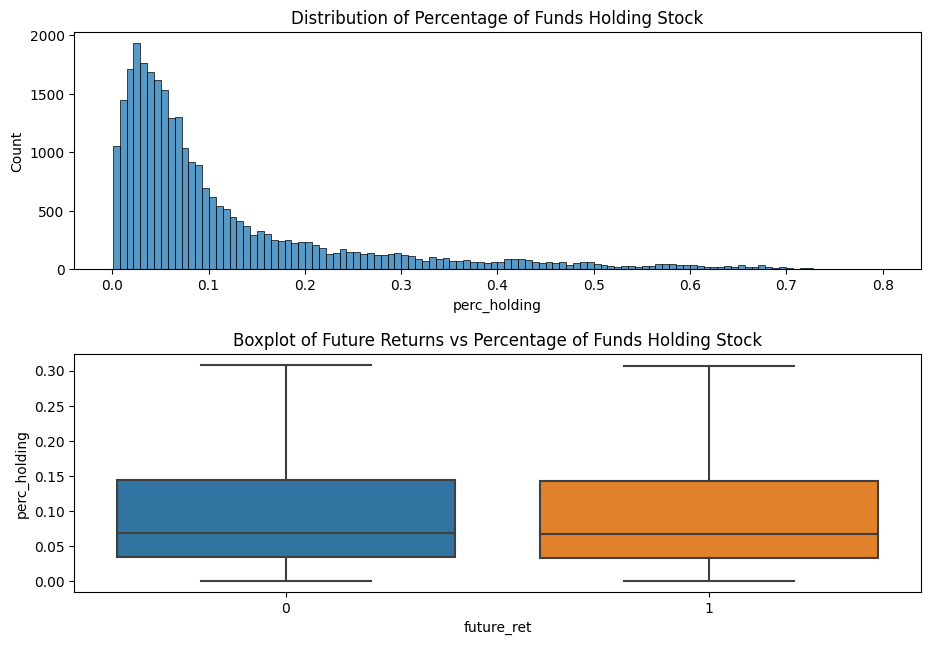

In [7]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="perc_holding", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of Percentage of Funds Holding Stock")

sns.boxplot(data=pd.concat([train_X,train_Y],axis=1), x="future_ret",y="perc_holding",ax=ax[1], showfliers = False)
ax[1].set_title("Boxplot of Future Returns vs Percentage of Funds Holding Stock")
plt.show()

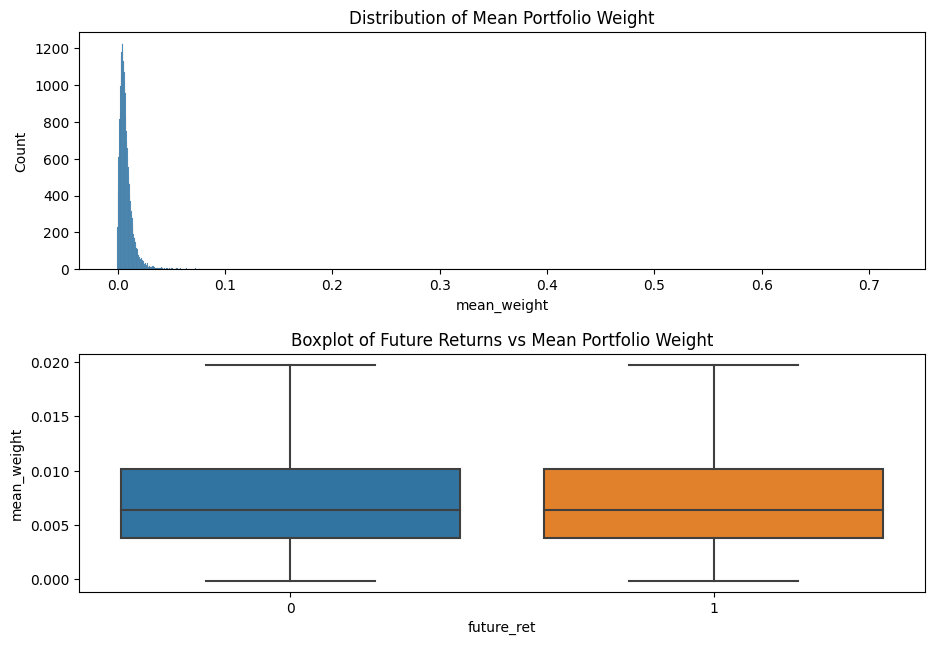

In [8]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="mean_weight", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of Mean Portfolio Weight")

sns.boxplot(data=pd.concat([train_X,train_Y],axis=1), x="future_ret",y="mean_weight",ax=ax[1], showfliers = False)
ax[1].set_title("Boxplot of Future Returns vs Mean Portfolio Weight")
plt.show()

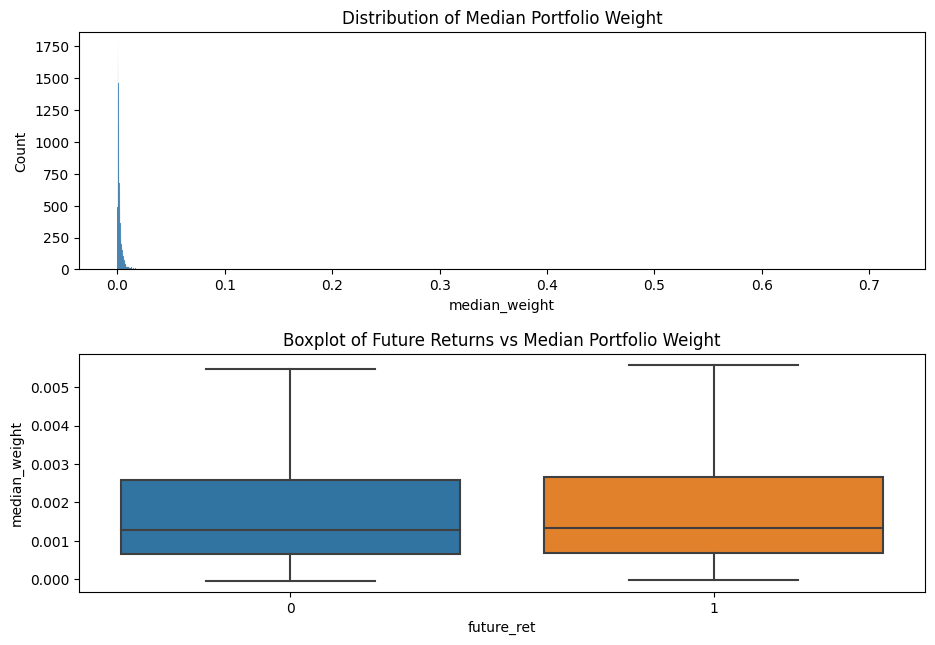

In [9]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="median_weight", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of Median Portfolio Weight")

sns.boxplot(data=pd.concat([train_X,train_Y],axis=1), x="future_ret",y="median_weight",ax=ax[1], showfliers = False)
ax[1].set_title("Boxplot of Future Returns vs Median Portfolio Weight")
plt.show()

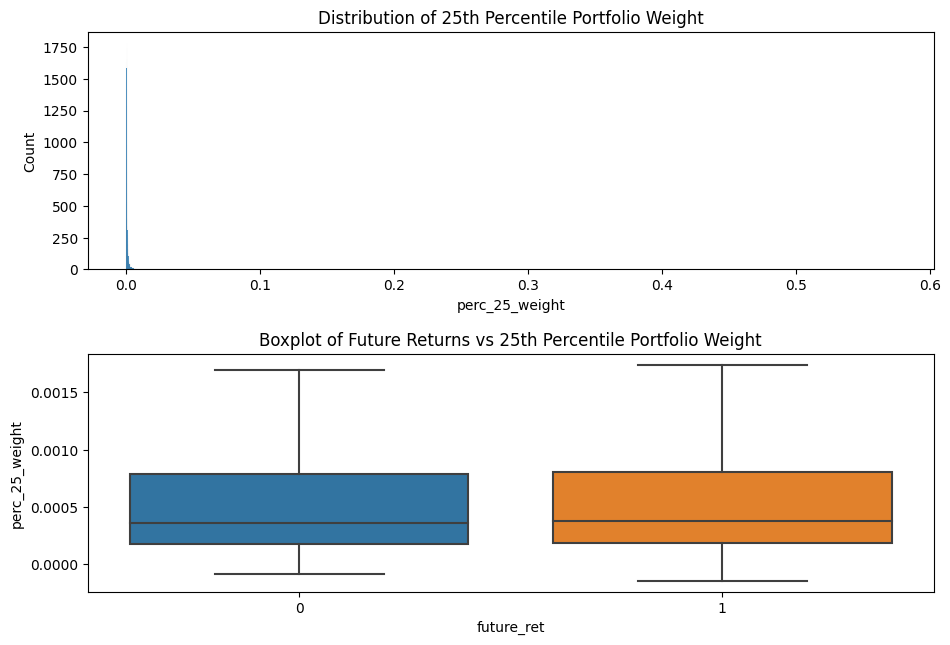

In [10]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="perc_25_weight", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of 25th Percentile Portfolio Weight")

sns.boxplot(data=pd.concat([train_X,train_Y],axis=1), x="future_ret",y="perc_25_weight",ax=ax[1], showfliers = False)
ax[1].set_title("Boxplot of Future Returns vs 25th Percentile Portfolio Weight")
plt.show()

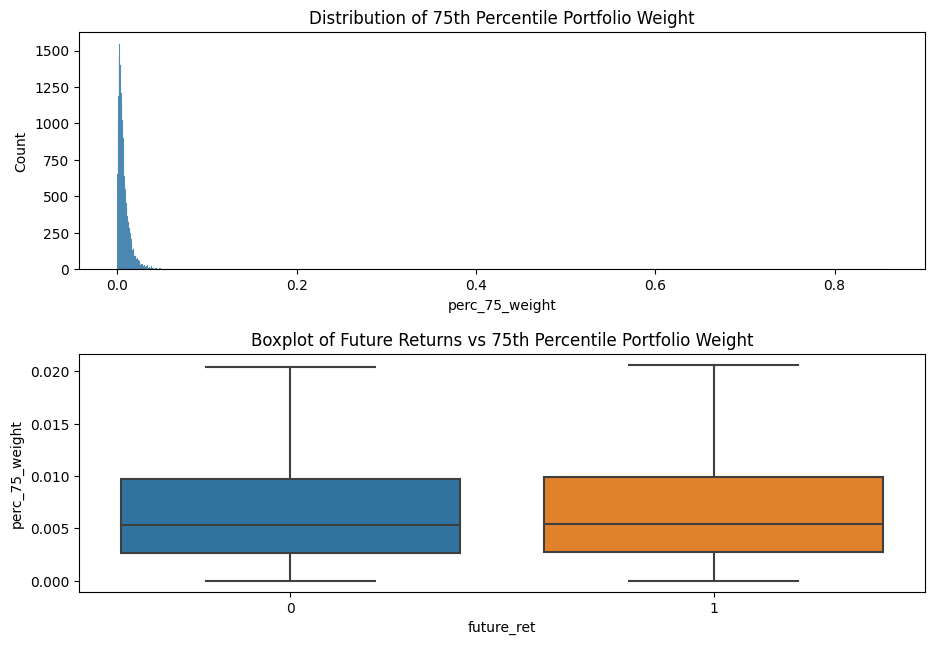

In [11]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="perc_75_weight", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of 75th Percentile Portfolio Weight")

sns.boxplot(data=pd.concat([train_X,train_Y],axis=1), x="future_ret",y="perc_75_weight",ax=ax[1], showfliers = False)
ax[1].set_title("Boxplot of Future Returns vs 75th Percentile Portfolio Weight")
plt.show()

<AxesSubplot: >

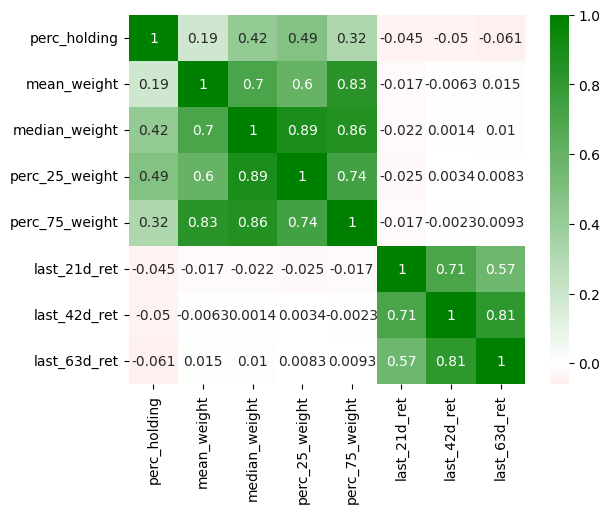

In [12]:
from matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
sns.heatmap(train_X.corr(method="spearman"), annot=True, cmap=cmap, center=0)

# Baseline Model

In [13]:
print(classification_report(train_Y, [1] * len(train_Y), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10925
           1       0.62      1.00      0.77     18134

    accuracy                           0.62     29059
   macro avg       0.31      0.50      0.38     29059
weighted avg       0.39      0.62      0.48     29059



In [14]:
print(classification_report(test_Y, [1] * len(test_Y), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3611
           1       0.59      1.00      0.75      5299

    accuracy                           0.59      8910
   macro avg       0.30      0.50      0.37      8910
weighted avg       0.35      0.59      0.44      8910



# Logistic Regression

In [15]:
LR = LogisticRegression(max_iter=500)
LR.fit(train_X,train_Y)
lr_pred_train_Y = LR.predict(train_X)
lr_pred_test_Y = LR.predict(test_X)

In [16]:
print(classification_report(train_Y, lr_pred_train_Y))

              precision    recall  f1-score   support

           0       0.31      0.00      0.00     10925
           1       0.62      1.00      0.77     18134

    accuracy                           0.62     29059
   macro avg       0.47      0.50      0.39     29059
weighted avg       0.51      0.62      0.48     29059



In [17]:
print(classification_report(test_Y, lr_pred_test_Y))

              precision    recall  f1-score   support

           0       0.12      0.01      0.02      3611
           1       0.58      0.94      0.72      5299

    accuracy                           0.57      8910
   macro avg       0.35      0.48      0.37      8910
weighted avg       0.40      0.57      0.44      8910



# Baseline XGB

In [18]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(train_X, train_Y)
xgb_pred_train_Y = xgb_model.predict(train_X)
xgb_pred_test_Y = xgb_model.predict(test_X)

In [19]:
print(classification_report(train_Y, xgb_pred_train_Y))

              precision    recall  f1-score   support

           0       0.90      0.37      0.53     10925
           1       0.72      0.97      0.83     18134

    accuracy                           0.75     29059
   macro avg       0.81      0.67      0.68     29059
weighted avg       0.79      0.75      0.72     29059



In [20]:
print(classification_report(test_Y, xgb_pred_test_Y))

              precision    recall  f1-score   support

           0       0.41      0.20      0.27      3611
           1       0.60      0.81      0.69      5299

    accuracy                           0.56      8910
   macro avg       0.50      0.50      0.48      8910
weighted avg       0.52      0.56      0.52      8910



# Hyperparameter Tuning + Cross validation

In [21]:
# For bayesian optimisation hyperparameter tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [43]:
from sklearn.metrics import f1_score
import numpy as np

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

def get_xgb_best_param(train_X, train_Y):
    curr_best_rounds = 0
    # Search range
    xgb_parameters = {
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'max_depth': hp.quniform("max_depth", 3, 10, 1),
        "eta": hp.uniform("eta", 0.1, 0.5),
        'gamma': hp.uniform ('gamma', 0,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        "subsample": hp.uniform("subsample", 0.5, 1),
        'reg_alpha' : hp.choice('reg_alpha', [0.001, 0.01, 0.1, 1, 10, 100]),
    }

    def xgb_objective_func(space):
        params = {
            'objective':"binary:logistic",
            'colsample_bytree':space["colsample_bytree"],
            'max_depth':int(space["max_depth"]),
            'eta':space["eta"],
            'gamma':space["gamma"],
            'min_child_weight':int(space["min_child_weight"]),
            'subsample':space["subsample"],
            'reg_alpha':space["reg_alpha"]
        }
        
        
        # Set num boost rounds to a high number and rely on early stopping round
        xgb_cv = xgb.cv(dtrain=xgb.DMatrix(train_X,train_Y), 
                        params=params, 
                        nfold=3,
                        num_boost_round=500, 
                        early_stopping_rounds=10, 
                        custom_metric=f1_eval,
                        as_pandas=True, 
                        seed=123)
        min_loss = xgb_cv['test-f1_err-mean'].min()
        nonlocal curr_best_rounds
        curr_best_rounds = xgb_cv['test-f1_err-mean'].argmin()
        return {'loss': min_loss, 'status': STATUS_OK}

    trials = Trials()

    xgb_best_param = fmin(fn = xgb_objective_func,
                      space = xgb_parameters,
                      algo = tpe.suggest,
                      max_evals = 100,
                      trials = trials)      
    xgb_best_param["n_estimators"] = curr_best_rounds
    
    return xgb_best_param

In [23]:
xgb_best_param = get_xgb_best_param(train_X,train_Y)

100%|██████████| 100/100 [01:42<00:00,  1.02s/trial, best loss: 0.231263]         


In [24]:
xgb_best_param

{'colsample_bytree': 0.7122412758168631,
 'eta': 0.38304005029501803,
 'gamma': 0.6947335711666859,
 'max_depth': 5.0,
 'min_child_weight': 3.0,
 'reg_alpha': 5,
 'subsample': 0.6733914396131511,
 'n_estimators': 4}

In [35]:
tuned_xgb_model = xgb.XGBClassifier(
                      objective="binary:logistic",
                      colsample_bytree = xgb_best_param["colsample_bytree"], 
                      max_depth=int(xgb_best_param["max_depth"]),
                      eta=xgb_best_param["eta"],
                      gamma=xgb_best_param["gamma"],
                      min_child_weight=int(xgb_best_param["min_child_weight"]),
                      subsample=xgb_best_param["subsample"],
                      reg_alpha=xgb_best_param["reg_alpha"],
                      verbosity=1,
                      eval_metric=f1_eval,
                      n_estimators=xgb_best_param["n_estimators"],
                      random_state=123)
tuned_xgb_model.fit(train_X, train_Y)    

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7122412758168631, early_stopping_rounds=None,
              enable_categorical=False, eta=0.38304005029501803,
              eval_metric=<function f1_eval at 0x000002AB61FD7F70>,
              feature_types=None, gamma=0.6947335711666859, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=4, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [36]:
tuned_xgb_pred_train_Y = tuned_xgb_model.predict(train_X)
tuned_xgb_pred_test_Y = tuned_xgb_model.predict(test_X)

In [37]:
print(classification_report(train_Y, tuned_xgb_pred_train_Y))

              precision    recall  f1-score   support

           0       0.69      0.02      0.03     10925
           1       0.63      1.00      0.77     18134

    accuracy                           0.63     29059
   macro avg       0.66      0.51      0.40     29059
weighted avg       0.65      0.63      0.49     29059



In [38]:
print(classification_report(test_Y, tuned_xgb_pred_test_Y))

              precision    recall  f1-score   support

           0       0.34      0.01      0.02      3611
           1       0.59      0.99      0.74      5299

    accuracy                           0.59      8910
   macro avg       0.47      0.50      0.38      8910
weighted avg       0.49      0.59      0.45      8910



# Oversampling - SMOTE

In [39]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
train_X_smote, train_Y_smote = oversample.fit_resample(train_X, train_Y)

In [40]:
train_Y_smote.value_counts()

1    18134
0    18134
Name: future_ret, dtype: int64

In [45]:
xgb_best_param_smote = get_xgb_best_param(train_X_smote,train_Y_smote)

100%|██████████| 100/100 [07:01<00:00,  4.21s/trial, best loss: 0.42649066666666674]


In [46]:
xgb_best_param_smote

{'colsample_bytree': 0.7010878651571814,
 'eta': 0.2502944195361715,
 'gamma': 0.7934760409578293,
 'max_depth': 8.0,
 'min_child_weight': 6.0,
 'reg_alpha': 4,
 'subsample': 0.9154709626440051,
 'n_estimators': 34}

In [47]:
tuned_xgb_model_smote = xgb.XGBClassifier(
                      objective='binary:logistic',
                      colsample_bytree = xgb_best_param_smote["colsample_bytree"], 
                      max_depth=int(xgb_best_param_smote["max_depth"]),
                      eta=xgb_best_param_smote["eta"],
                      gamma=xgb_best_param_smote["gamma"],
                      min_child_weight=int(xgb_best_param_smote["min_child_weight"]),
                      subsample=xgb_best_param_smote["subsample"],
                      reg_alpha=xgb_best_param_smote["reg_alpha"],
                      verbosity=1,
                      eval_metric="aucpr",
                      n_estimators=xgb_best_param_smote["n_estimators"],
                      random_state=123)
tuned_xgb_model_smote.fit(train_X_smote, train_Y_smote)    

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7010878651571814, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2502944195361715,
              eval_metric='aucpr', feature_types=None, gamma=0.7934760409578293,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=34, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [48]:
tuned_xgb_pred_train_Y_smote = tuned_xgb_model_smote.predict(train_X_smote)
tuned_xgb_pred_test_Y_smote = tuned_xgb_model_smote.predict(test_X)

In [49]:
print(classification_report(train_Y_smote, tuned_xgb_pred_train_Y_smote))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71     18134
           1       0.71      0.71      0.71     18134

    accuracy                           0.71     36268
   macro avg       0.71      0.71      0.71     36268
weighted avg       0.71      0.71      0.71     36268



In [51]:
print(classification_report(test_Y, tuned_xgb_pred_test_Y_smote))

              precision    recall  f1-score   support

           0       0.41      0.56      0.47      3611
           1       0.60      0.45      0.51      5299

    accuracy                           0.49      8910
   macro avg       0.50      0.50      0.49      8910
weighted avg       0.52      0.49      0.50      8910



# Simple Portfolio

In [322]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2000-01-01', end='2022-12-31').to_pydatetime()

# If deadline falls on Sat, Sun or Holiday, move to next business day
def get_filing_deadline(quarter_end):
    curr_deadline = quarter_end + datetime.timedelta(days=45)
    while curr_deadline.weekday() >= 5 or curr_deadline in holidays:
        curr_deadline = curr_deadline + datetime.timedelta(days=1)
    return curr_deadline

In [323]:
close_data = pd.read_csv('raw_data/close_data.csv', index_col=0)
close_data.index = pd.to_datetime(close_data.index)

In [324]:
def get_portfolio_return(df, benchmark=False):
    rebalance_date = df.index[0][0]
    top_tickers = df[df.pred == 1].index.get_level_values(1)
    if benchmark:
        top_tickers = df.index.get_level_values(1)
    next_deadline = get_filing_deadline(rebalance_date + pd.tseries.offsets.QuarterEnd())
    return close_data.pct_change().loc[rebalance_date:next_deadline,top_tickers].mean(axis=1)

In [325]:
# Take top stocks and equally weigh them
pf1_rets = pd.concat([train_y_df,test_y_df_smote]).groupby('rebalance_date').apply(get_portfolio_return).reset_index(level=0,drop=True)

In [326]:
# Take all stocks in stock universe and equally weigh them
pf2_rets = pd.concat([train_y_df,test_y_df_smote]).groupby('rebalance_date').apply(
    lambda x:get_portfolio_return(x, benchmark=True)).reset_index(level=0,drop=True)

In [327]:
# Returns for just holding SPY (benchmark)
spy_rets = close_data["SPY"].pct_change()

In [328]:
def get_portfolio_statistics(pf, start_date, end_date, label, exclude_date_range=()):
    filtered_pf = pf.loc[start_date:end_date]
    if exclude_date_range:
        filtered_pf = filtered_pf.loc[~filtered_pf.index.isin(pd.date_range(start=exclude_date_range[0], end=exclude_date_range[1]))]
    pf_ann_ret = np.prod(1+filtered_pf)**(252/len(filtered_pf)) - 1
    pf_ann_vol = filtered_pf.std() * np.sqrt(252)
    print(label)
    print("----------------------------------------------------")
    print(f"Annualized returns of portfolio: {round(pf_ann_ret * 100,2)}%")
    print(f"Annualized volatility of test portfolio: {round(pf_ann_vol * 100,2)}%")
    print(f"Return-Risk Ratio of test portfolio: {round(pf_ann_ret/pf_ann_vol,4)}")
    print(f"Parametric Method - 5% VaR: {round((pf_ann_ret - 1.64 * pf_ann_vol) * 100,2)}%")
    print("")
    
def plot_portfolio_ts(start_date, end_date):
    pfs = pd.DataFrame({"Portfolio 1": pf1_rets, "SPY": spy_rets})
    pfs = pfs.loc[start_date:end_date]
    cumrets = (1+pfs).cumprod()
    plt.figure(figsize=(10,3))
    sns.lineplot(cumrets)

Portfolio 1 statistics for test date range
----------------------------------------------------
Annualized returns of portfolio: 17.89%
Annualized volatility of test portfolio: 27.55%
Return-Risk Ratio of test portfolio: 0.6494
Parametric Method - 5% VaR: -27.29%

Benchmark Portfolio statistics for test date range
----------------------------------------------------
Annualized returns of portfolio: 17.77%
Annualized volatility of test portfolio: 26.14%
Return-Risk Ratio of test portfolio: 0.6798
Parametric Method - 5% VaR: -25.1%

SPY portfolio statistics for test date range
----------------------------------------------------
Annualized returns of portfolio: 13.92%
Annualized volatility of test portfolio: 22.44%
Return-Risk Ratio of test portfolio: 0.6202
Parametric Method - 5% VaR: -22.89%



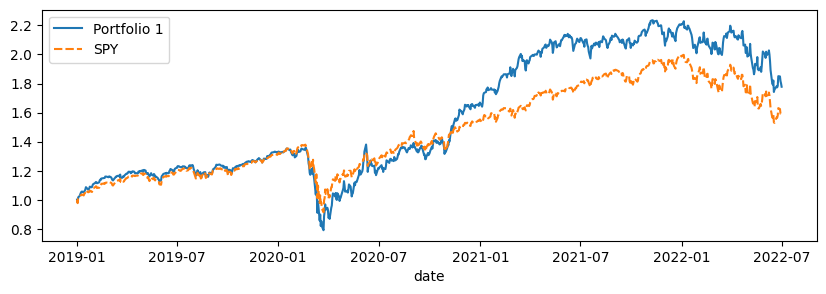

In [329]:
get_portfolio_statistics(pf1_rets, "2019-01-01", "2022-06-30","Portfolio 1 statistics for test date range")
get_portfolio_statistics(pf2_rets, "2019-01-01", "2022-06-30","Benchmark Portfolio statistics for test date range")
get_portfolio_statistics(spy_rets, "2019-01-01", "2022-06-30","SPY portfolio statistics for test date range")
plot_portfolio_ts("2019-01-01", "2022-06-30")

In [173]:
# Excluding covid crash (20 February 2020 to 7 April 2020)
get_portfolio_statistics(pf1_rets, "2019-01-01", "2022-06-30","Portfolio 1 statistics for test date range excluding Covid crash", ["2020-02-20","2020-04-07"])
get_portfolio_statistics(spy_rets, "2019-01-01", "2022-06-30","SPY portfolio statistics for test date range excluding Covid crash", ["2020-02-20","2020-04-07"])

Portfolio 1 statistics for test date range excluding Covid crash
----------------------------------------------------
Annualized returns of portfolio: 30.68%
Annualized volatility of test portfolio: 19.89%
Return-Risk Ratio of test portfolio: 1.5423
Parametric Method - 5% VaR: -1.94%

SPY portfolio statistics for test date range excluding Covid crash
----------------------------------------------------
Annualized returns of portfolio: 22.92%
Annualized volatility of test portfolio: 16.97%
Return-Risk Ratio of test portfolio: 1.3505
Parametric Method - 5% VaR: -4.91%



In [174]:
# Only crisis period
get_portfolio_statistics(pf1_rets, "2020-02-20", "2020-04-07","Portfolio 1 statistics for Covid crash")
get_portfolio_statistics(spy_rets, "2020-02-20", "2020-04-07","SPY Portfolio statistics for Covid crash")

Portfolio 1 statistics for Covid crash
----------------------------------------------------
Annualized returns of portfolio: -91.13%
Annualized volatility of test portfolio: 88.07%
Return-Risk Ratio of test portfolio: -1.0347
Parametric Method - 5% VaR: -235.57%

SPY Portfolio statistics for Covid crash
----------------------------------------------------
Annualized returns of portfolio: -82.86%
Annualized volatility of test portfolio: 77.05%
Return-Risk Ratio of test portfolio: -1.0754
Parametric Method - 5% VaR: -209.22%



Portfolio 1 statistics for 2019-01-01 to 2019-12-31
----------------------------------------------------
Annualized returns of portfolio: 31.95%
Annualized volatility of test portfolio: 13.56%
Return-Risk Ratio of test portfolio: 2.3561
Parametric Method - 5% VaR: 9.71%

SPY portfolio statistics for 2019-01-01 to 2019-12-31
----------------------------------------------------
Annualized returns of portfolio: 31.22%
Annualized volatility of test portfolio: 12.51%
Return-Risk Ratio of test portfolio: 2.4957
Parametric Method - 5% VaR: 10.71%



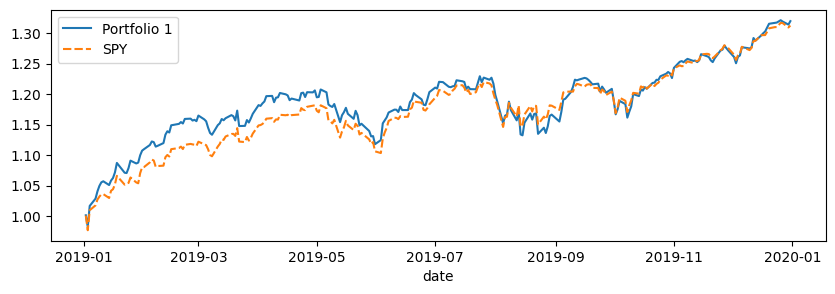

In [175]:
# Compare against previous study(2019-01-01 to 2019-12-31)
get_portfolio_statistics(pf1_rets, "2019-01-01", "2019-12-31","Portfolio 1 statistics for 2019-01-01 to 2019-12-31")
get_portfolio_statistics(spy_rets, "2019-01-01", "2019-12-31","SPY portfolio statistics for 2019-01-01 to 2019-12-31")
plot_portfolio_ts("2019-01-01", "2019-12-31")

Portfolio 1 statistics for 2013-09-30 to 2017-12-31
----------------------------------------------------
Annualized returns of portfolio: 16.51%
Annualized volatility of test portfolio: 13.1%
Return-Risk Ratio of test portfolio: 1.2605
Parametric Method - 5% VaR: -4.97%

SPY portfolio statistics for 2013-09-30 to 2017-12-31
----------------------------------------------------
Annualized returns of portfolio: 13.62%
Annualized volatility of test portfolio: 11.95%
Return-Risk Ratio of test portfolio: 1.1396
Parametric Method - 5% VaR: -5.98%



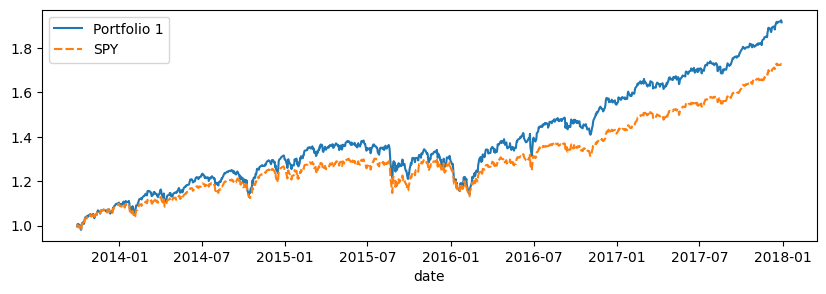

In [176]:
# Compare against previous study(2013-09-30 to 2017-12-31)
get_portfolio_statistics(pf1_rets, "2013-09-30", "2017-12-31","Portfolio 1 statistics for 2013-09-30 to 2017-12-31")
get_portfolio_statistics(spy_rets, "2013-09-30", "2017-12-31","SPY portfolio statistics for 2013-09-30 to 2017-12-31")
plot_portfolio_ts("2013-09-30", "2017-12-31")